In [1]:
from db_connection import DB_Connection
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import TextBox
import re, json
from wordcloud import WordCloud
import Tweet


db = DB_Connection()

database = db.query('''SELECT * FROM TWTTWEET WHERE TWEET_CREATED<'2021-01-01'
                    ORDER BY TWEET_CREATED DESC;''')
df = pd.DataFrame(database, columns=['id','userid','text','date',
                            'link','media1','media2','media3', 'media4'])
df = df.loc[:, ['id', 'text']]


processed = Tweet.clean_text(df, 'text')
classified = Tweet.classify_text(processed, 'clean')

# incidents = classified[['id','isIncident']].groupby('isIncident').size()
# accidents = classified[['id','isAccident']].groupby('isAccident').size()[1]
# dangers = classified[['id','isDanger']].groupby('isDanger').size()[1]
# obstacles = classified[['id','isObstacle']].groupby('isObstacle').size()[1]

Connection succesful.


In [ ]:
joined = ' '.join([t for t in classified.clean])
joined = joined.split()
new_joined = pd.Series(joined)

In [ ]:
len(new_joined.unique())

In [ ]:
x = [0,1,2]
data = [accidents,obstacles,dangers]
plt.figure(figsize=(10,6))
g = sns.barplot(x=x, y=data)
plt.title('% de incidentes por categoría', fontsize=16)
plt.xticks(ticks=x,
        labels=['accidentes','obstáculos','peligros'],
        fontsize=13)
plt.ylim(top=65000)

for i, v in enumerate(data):
    g.text(i, v+1000, v, color='black', ha="center", fontsize=12)
    # plt.annotate(v, (i+3, 10), color='black', fontsize=12)
plt.show()

## Text classification

In [2]:
from sklearn.svm import LinearSVC
import pickle
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
classified.head(1)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(max_features=600, min_df=5, max_df=0.7)
X11 = vectorizer1.fit_transform(classified.clean).toarray()

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X2 = tfidf.fit_transform(X1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfi = TfidfVectorizer(sublinear_tf=True, max_features=500, min_df=5, max_df=0.7, encoding='utf-8', ngram_range=(1,2))
X3 = tfi.fit_transform(classified.clean).toarray()
# labels = classified.isIncident

In [4]:
y = [i for i in classified[['isAccident','isObstacle','isDanger']].values]

In [5]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X11, y, test_size=0.2, random_state=0)

### Boosting Model

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb
import time
from xgboost import DMatrix
from sklearn.metrics import roc_auc_score

In [8]:
from xgboost import XGBClassifier

start = time.time()
xgb_first = XGBClassifier()
mo_classifier = MultiOutputClassifier(xgb_first).fit(X_train1, y_train1)
# xgb_first.fit(X_train1, y_train1)
end = time.time()
print('Duration:', str(end-start))
y_xgb_first = mo_classifier.predict(X_test1)

[21:26:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Duration: 342.79028272628784


In [9]:
for i in range(3):
    ytest0 = [j[i] for j in y_test1] 
    ypred0 = [j[i] for j in y_xgb_first]
    print('Acurracy data[%d]'%i, accuracy_score(ytest0, ypred0))

Acurracy data[0] 0.9960387574807638
Acurracy data[1] 0.985779424337418
Acurracy data[2] 0.9980621259618124


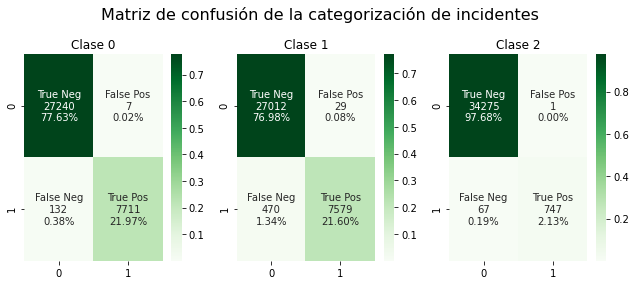

In [10]:
conf_matrix = multilabel_confusion_matrix(y_test1,y_xgb_first)

plt.figure(figsize=(9,4))
plt.suptitle('Matriz de confusión de la categorización de incidentes', fontsize=16)
for i in range(3):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    conf_matrix[i].flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        conf_matrix[i].flatten()/np.sum(conf_matrix[i])]
    labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.subplot(1, 3, i+1)
    sns.heatmap(conf_matrix[i]/np.sum(conf_matrix[i]), annot=labels, fmt='', cmap='Greens')
    plt.title('Clase %d'%i, fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
param_test0 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

start = time.time()
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=6,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, 
                                        eval_metric='error', seed=27), 
                        param_grid = param_test0, scoring='accuracy',n_jobs=4, cv=3, verbose=2)
grid_result0 = MultiOutputClassifier(gsearch0).fit(X_train1, y_train1)
end = time.time()
print(str(end-start))
with open('param_test0', 'wb') as picklefile:
    pickle.dump(grid_result0, picklefile)
for i in range(3):
    grid_results0 = pd.DataFrame(grid_result0.estimators_[i].cv_results_)
    grid_results0.to_csv('grid_results0-%d.csv'%(i))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
6813.413553237915


In [11]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,4)]
}

start = time.time()
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100,
                                        max_depth=9,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        eval_metric='error', objective= 'binary:logistic',
                                        nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=3, verbose=1)
grid_result1 = MultiOutputClassifier(gsearch1).fit(X_train1, y_train1)
end = time.time()
print(str(end-start))
with open('param_test1', 'wb') as picklefile:
    pickle.dump(grid_result1, picklefile)
for i in range(3):
    grid_results1 = pd.DataFrame(grid_result1.estimators_[i].cv_results_)
    grid_results1.to_csv('grid_results1-%d.csv'%(i))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
3973.1002860069275


In [7]:
param_test2 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}

start = time.time()
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, 
                                        max_depth=9,
                                        min_child_weight=1, gamma=0,
                                        subsample=0.8, colsample_bytree=0.8,
                                        eval_metric='error', objective= 'binary:logistic',
                                        nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test2, scoring='accuracy',n_jobs=4, cv=3, verbose=1)
print('Fitting...')
grid_result2 = MultiOutputClassifier(gsearch2).fit(X_train1, y_train1)
end = time.time()
print(str(end-start))
with open('param_test2', 'wb') as picklefile:
    pickle.dump(grid_result2, picklefile)
for i in range(3):
    grid_results2 = pd.DataFrame(grid_result2.estimators_[i].cv_results_)
    grid_results2.to_csv('grid_results2-%d.csv'%(i))

Fitting...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
19401.869418144226


In [168]:
param_test3 = {
 'reg_alpha':[0, 1e-5, 0.001, 0.005, 0.01, 0.05, 0.1]
}

print('Starting.')
start = time.time()
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100,
                                        max_depth=9,
                                        min_child_weight=1, gamma=0,
                                        subsample=0.9, colsample_bytree=1,
                                        eval_metric='error', objective= 'binary:logistic',
                                        nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test3, scoring='accuracy',n_jobs=4, cv=3, verbose=1)
print('Fitting...')
grid_result3 = MultiOutputClassifier(gsearch3).fit(X_train1, y_train1)
end = time.time()
print(str(end-start))
with open('param_test3', 'wb') as picklefile:
    pickle.dump(grid_result3, picklefile)
for i in range(3):
    grid_results3 = pd.DataFrame(grid_result3.estimators_[i].cv_results_)
    grid_results3.to_csv('grid_results3-%d.csv'%(i))

Starting.
Fitting...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
7408.464740514755


#### Estimators adjust

In [23]:
moresume = []
mo_arr = []

for i in [248,512,1024,2048]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0, reg_alpha=0.005,
        subsample=0.9, colsample_bytree=1,
        nthread=4, seed=27, eval_metric='error', verbosity=1)
    mo = MultiOutputClassifier(xgb)
    mo_arr.append(mo)
    print('Fitting... ', time.asctime())
    mo_arr[-1].fit(X_train1, y_train1)
    end = time.time()
    print('Predicting... ', time.asctime())
    y_mo = mo_arr[-1].predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_mo))
    moresume.append([i, end-start, accuracy_score(y_test1, y_mo)])


estimators: 248
Fitting...  Sun Feb 21 23:39:21 2021
Predicting...  Mon Feb 22 00:02:19 2021
1377.630497455597 0.9810202336848105

estimators: 512
Fitting...  Mon Feb 22 00:02:21 2021
Predicting...  Mon Feb 22 00:53:56 2021
3094.870729446411 0.9815616984895982

estimators: 1024
Fitting...  Mon Feb 22 00:53:58 2021
Predicting...  Mon Feb 22 02:38:05 2021
6246.417376041412 0.9817326873753206

estimators: 2048
Fitting...  Mon Feb 22 02:38:08 2021
Predicting...  Mon Feb 22 06:05:49 2021
12460.35061264038 0.9818751781134226


In [26]:
print('\nestimators: 4096')
start = time.time()
xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=4096,
        max_depth=9, min_child_weight=1,
        gamma=0, reg_alpha=0.005,
        subsample=0.9, colsample_bytree=1,
        nthread=4, seed=27, eval_metric='error', verbosity=1)
mo = MultiOutputClassifier(xgb)
mo_arr.append(mo)
print('Fitting... ', time.asctime())
mo_arr[-1].fit(X_train1, y_train1)
end = time.time()
print('Predicting... ', time.asctime())
y_mo = mo_arr[-1].predict(X_test1)
print(str(end-start), accuracy_score(y_test1, y_mo))
moresume.append([4096, end-start, accuracy_score(y_test1, y_mo)])


estimators: 4096
Fitting...  Mon Feb 22 10:12:31 2021
Predicting...  Mon Feb 22 17:00:43 2021
24492.738333702087 0.9811912225705329


In [27]:
with open('moresume0', 'wb') as picklefile:
    pickle.dump(moresume, picklefile)
with open('moarr0', 'wb') as picklefile:
    pickle.dump(mo_arr, picklefile)

In [28]:
moresume1 = []
mo_arr1 = []

for i in [2100, 2300, 2500, 3000, 3500]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0, reg_alpha=0.005,
        subsample=0.9, colsample_bytree=1,
        nthread=4, seed=27, eval_metric='error', verbosity=1)
    mo = MultiOutputClassifier(xgb)
    mo_arr1.append(mo)
    print('Fitting... ', time.asctime())
    mo_arr1[-1].fit(X_train1, y_train1)
    end = time.time()
    print('Predicting... ', time.asctime())
    y_mo = mo_arr1[-1].predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_mo))
    moresume1.append([i, end-start, accuracy_score(y_test1, y_mo)])


estimators: 2100
Fitting...  Mon Feb 22 17:00:58 2021
Predicting...  Mon Feb 22 20:30:35 2021
12576.946767091751 0.9818466799658022

estimators: 2300
Fitting...  Mon Feb 22 20:30:41 2021
Predicting...  Tue Feb 23 00:21:38 2021
13857.196723937988 0.9819321744086634

estimators: 2500
Fitting...  Tue Feb 23 00:21:44 2021
Predicting...  Tue Feb 23 04:33:16 2021
15091.859599113464 0.9817896836705614

estimators: 3000
Fitting...  Tue Feb 23 04:33:23 2021
Predicting...  Tue Feb 23 09:34:23 2021
18060.39907836914 0.9815616984895982

estimators: 3500
Fitting...  Tue Feb 23 09:34:31 2021
Predicting...  Tue Feb 23 15:25:29 2021
21058.14136505127 0.9816756910800798


In [48]:
with open('moresume1', 'wb') as picklefile:
    pickle.dump(moresume1, picklefile)
with open('moarr1', 'wb') as picklefile:
    pickle.dump(mo_arr1, picklefile)

In [49]:
for i in [2200, 2250, 2300, 2350, 2400]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0, reg_alpha=0.005,
        subsample=0.9, colsample_bytree=1,
        nthread=4, seed=27, eval_metric='error', verbosity=1)
    mo = MultiOutputClassifier(xgb)
    mo_arr1.append(mo)
    print('Fitting... ', time.asctime())
    mo_arr1[-1].fit(X_train1, y_train1)
    end = time.time()
    print('Predicting... ', time.asctime())
    y_mo = mo_arr1[-1].predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_mo))
    moresume1.append([i, end-start, accuracy_score(y_test1, y_mo)])


estimators: 2200
Fitting...  Tue Feb 23 17:55:46 2021
Predicting...  Tue Feb 23 21:59:06 2021
14599.626916408539 0.9817041892277002

estimators: 2250
Fitting...  Tue Feb 23 21:59:12 2021
Predicting...  Wed Feb 24 01:48:13 2021
13740.518744468689 0.9817041892277002

estimators: 2300
Fitting...  Wed Feb 24 01:48:19 2021
Predicting...  Wed Feb 24 12:51:17 2021
39778.19322133064 0.9819321744086634

estimators: 2350
Fitting...  Wed Feb 24 12:52:23 2021
Predicting...  Wed Feb 24 17:03:57 2021
15094.654872655869 0.9819321744086634

estimators: 2400
Fitting...  Wed Feb 24 17:11:48 2021
Predicting...  Wed Feb 24 21:21:11 2021
14962.715512037277 0.9818181818181818


In [50]:
with open('moresume1-1', 'wb') as picklefile:
    pickle.dump(moresume1, picklefile)
with open('moarr1-1', 'wb') as picklefile:
    pickle.dump(mo_arr1, picklefile)
print('Done.')

Done.


In [51]:
mo_final = mo_arr1[-3]
y_mo_final = mo_final.predict(X_test1)

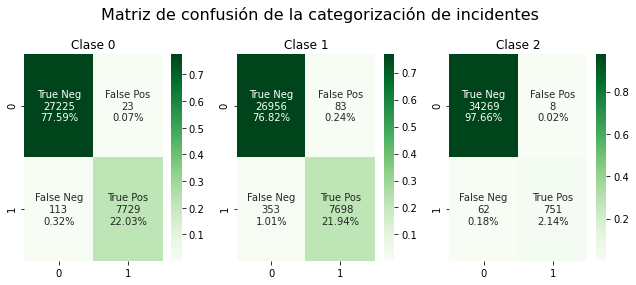

In [53]:
conf_matrix = multilabel_confusion_matrix(y_test1,y_mo_final)

plt.figure(figsize=(9,4))
plt.suptitle('Matriz de confusión de la categorización de incidentes', fontsize=16)
for i in range(3):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    conf_matrix[i].flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        conf_matrix[i].flatten()/np.sum(conf_matrix[i])]
    labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.subplot(1, 3, i+1)
    sns.heatmap(conf_matrix[i]/np.sum(conf_matrix[i]), annot=labels, fmt='', cmap='Greens')
    plt.title('Clase %d'%i, fontsize=12)
plt.tight_layout()
plt.show()

In [52]:
with open('mo_classifier', 'wb') as picklefile:
    pickle.dump(mo_final, picklefile)

#### Count vectors adjust

In [ ]:
# load model
with open('xgb_classifier', 'rb') as training_model:
    xgb = pickle.load(training_model)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

xgresume2 = []
xgb_arr2 = []

for i in [800, 1000, 2000, 5000, 10000]:
    print('\nnumber of features:', str(i))
    vectorizer = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
    print('Fitting vectorizer...')
    X1 = vectorizer.fit_transform(classified.clean).toarray()
    print('Creating train-test data...')
    X_train, X_test, y_train, y_test = train_test_split(X1, classified.isIncident, test_size=0.2, random_state=0)
    print('Fitting model...', time.asctime())
    with open('xgb_classifier', 'rb') as training_model:
        xgb_arr2.append(pickle.load(training_model))
    start = time.time()
    xgb_arr2[-1].fit(X_train,y_train)
    end = time.time()
    print('Fitting time:', str(end-start), '\nPredicting...')
    y_xgb = xgb_arr2[-1].predict(X_test)
    print(accuracy_score(y_test, y_xgb))
    print(confusion_matrix(y_test,y_xgb))
    print(classification_report(y_test,y_xgb))
    xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])

In [ ]:
with open('xgbresume2', 'wb') as picklefile:
    pickle.dump(xgresume2, picklefile)
with open('xgbarr2', 'wb') as picklefile:
    pickle.dump(xgb_arr2, picklefile)

In [ ]:
# load model
with open('./others/resumes/xgbarr2', 'rb') as arr:
    xgb_arr2 = pickle.load(arr)
with open('./others/resumes/xgbresume2', 'rb') as resume:
    xgresume2 = pickle.load(resume)

In [ ]:
xs = [i[0] for i in xgresume2]
ys = [i[1] for i in xgresume2]
zs = [i[2] for i in xgresume2]

plt.figure(figsize=(9,3.5))
plt.suptitle('Resultados del ajuste de número de vectores', fontsize=16)
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

In [ ]:
# save final xgb model
xgb_final2 = xgb_arr2[-1]

In [ ]:
# fit vectorizer 5000 features
i = 5000
print('\nnumber of features:', str(i))
vectorizer10 = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
print('Fitting vectorizer...', time.asctime())
vectorizer10.fit(classified.clean)

In [ ]:
# convert and split data
X_vect = vect.transform(classified.clean).toarray()
print('Creating train-test data...')
X_train, X_test, y_train, y_test = train_test_split(X_vect, classified.isIncident, test_size=0.2, random_state=0)
print('Done.')

In [ ]:
with open('vectorizer5000', 'wb') as picklefile:
    pickle.dump(vectorizer10, picklefile)

In [ ]:
# load model fo 5000 features
with open('count_vectorizer', 'rb') as v:
    vect = pickle.load(v)

In [ ]:
#load model
with open('xgb_5000', 'rb') as training_model:
    xgb_classifier = pickle.load(training_model)

In [ ]:
# fit classifier with 5000 features
print('Fitting model...', time.asctime())
start = time.time()
xgb_classifier.fit(X_train,y_train)
end = time.time()
print('Fitting time:', str(end-start), '\nPredicting...')

In [ ]:
# predict test data
print('Predicting data...')
y_xgb2 = xgb_classifier.predict(X_test)
print(accuracy_score(y_test, y_xgb2))
print(confusion_matrix(y_test,y_xgb2))
print(classification_report(y_test,y_xgb2))
# xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb2),
# confusion_matrix(y_test,y_xgb2), classification_report(y_test,y_xgb2)])

In [ ]:
# save trained classifier
with open('xgb_features_final', 'wb') as picklefile:
    pickle.dump(xgb_classifier, picklefile)

In [ ]:
# count vectors for 10000
i = 10000
print('\nnumber of features:', str(i))
vectorizer100 = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
print('Fitting vectorizer...', time.asctime())
vectorizer100.fit(classified.clean)
X_vect1 = vectorizer100.transform(classified.clean).toarray()
print('Creating train-test data...')
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_vect1, classified.isIncident, test_size=0.2, random_state=0)
with open('vectorizer10000', 'wb') as picklefile:
    pickle.dump(vectorizer100, picklefile)

In [ ]:
# fitting 10000 vectors
#load model
with open('xgb_classifier', 'rb') as model:
    xgb_classifier1 = pickle.load(model)
print('Fitting model...', time.asctime())
start = time.time()
xgb_classifier1.fit(X_train3,y_train3)
end = time.time()
print('Fitting time:', str(end-start), '\nPredicting...')
y_xgb3 = xgb_classifier1.predict(X_test3)
print(accuracy_score(y_test3, y_xgb3))
print(confusion_matrix(y_test3,y_xgb3))
print(classification_report(y_test3,y_xgb3))
# xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb3),
# confusion_matrix(y_test,y_xgb3), classification_report(y_test,y_xgb3)])

In [ ]:
xgb_con = confusion_matrix(y_test,y_xgb2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                xgb_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     xgb_con.flatten()/np.sum(xgb_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,3.2))
sns.heatmap(xgb_con/np.sum(xgb_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para 5000 características', fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
feat_df = pd.DataFrame(X_vect)
feat_df.columns = vect.get_feature_names()

plt.figure(figsize=(10,3.5))
feat_imp = pd.Series(xgb_classifier.get_booster().get_fscore()).sort_values(ascending=False)[:40]
# feat_imp.plot(kind='bar', title='Feature] Importances')
feat_values = [int(re.sub('f', '', i)) for i in feat_imp.index]
feat_names = [feat_df.columns[i] for i in feat_values]
features = pd.DataFrame({'feature_num':feat_values, 'names':feat_names, 'count':feat_imp.values})
# plt.bar(x=feat_values, height=feat_imp.values)
# sns.barplot(x=feat_values, y=feat_imp.values, data=feat_imp, order=feat_imp.values)
plt.suptitle('Importancia de características', fontsize=16)
# plt.subplot(2, 1, 1)
sns.barplot(x='names', y='count', data=features)
plt.xticks(rotation=70, fontsize=12, ha='right')
plt.ylabel('Puntaje de características', fontsize=12)
# plt.tight_layout()
plt.xlabel(None)